0 2
1 2
2 2
3 3
4 3
5 3
6 3
7 3
8 3
9 2
10 2
11 2
12 2
13 3
14 3
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 3
30 3
31 3
32 2
33 3
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 1
43 1
44 2
45 2
46 2
47 1
48 2
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
['"alcohol"', '"volatile acidity"', '"sulphates"', '"total sulfur dioxide"', '"chlorides"', '"fixed acidity"', '"pH"', '"free sulfur dioxide"', '"residual sugar"', '"citric acid"', '"density"']


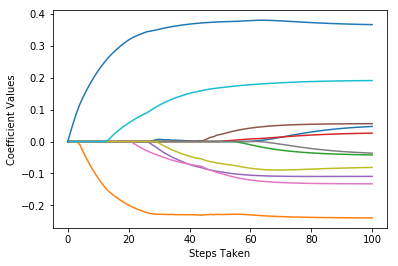

In [1]:
from urllib.request import urlopen
import numpy
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plot

def S(z, gamma):
    if gamma >= abs(z):
        return 0.0
    return (z/abs(z))*(abs(z) - gamma)

#read data into iterable
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
data = urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    line = line.decode()
    if firstLine:
        names = line.strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.strip().split(";")
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

#Normalize columns in x and labels

nrows = len(xList)
ncols = len(xList[0])

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(xList[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xSD.append(stdDev)
    
#use calculate mean and standard deviation to normalize xList
xNormalized = []
for i in range(nrows):
    rowNormalized = [(xList[i][j] - xMeans[j])/xSD[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)
    
#Normalize labels
meanLabel = sum(labels)/nrows
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrows)])/nrows)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrows)]

#select value for alpha parameter
alpha = 1.0

#make a pass through the data to determine value of lambda that
# just suppresses all coefficients.
#start with betas all equal to zero.

xy = [0.0] * ncols
for i in range(nrows):
    for j in range(ncols):
        xy[j] += xNormalized[i][j] * labelNormalized[i]

maxXY = 0.0
for i in range(ncols):
    val = abs(xy[i])/nrows
    if val > maxXY:
        maxXY = val
        
#calculate starting value for lambda
lam = maxXY/alpha

#this value of lambda corresponds to beta = list of 0's
#initialize a vector of coefficients beta
beta = [0.0] * ncols

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))

#begin iteration
nSteps = 100
lamMult = 0.93 #100 steps gives reduction by factor of 1000 in
               # lambda (recommended by authors)
nzList = []

for iStep in range(nSteps):
    #make lambda smaller so that some coefficient becomes non-zero
    lam = lam * lamMult
    
    deltaBeta = 100.0
    eps = 0.01
    iterStep = 0
    betaInner = list(beta)
    while deltaBeta > eps:
        iterStep += 1
        if iterStep > 100: break
        
        #cycle through attributes and update one-at-a-time
        #record starting value for comparison
        betaStart = list(betaInner)
        
        for iCol in range(ncols):
            xyj = 0.0
            for i in range(nrows):
                #calculate residual with current value of beta
                labelHat = sum([xNormalized[i][k]*betaInner[k] for k in range(ncols)])
                residual = labelNormalized[i] - labelHat
                xyj += xNormalized[i][iCol] * residual
            uncBeta = xyj/nrows + betaInner[iCol]
            betaInner[iCol] = S(uncBeta, lam * alpha) / (1 + lam * (1 - alpha))
        
        sumDiff = sum([abs(betaInner[n] - betaStart[n]) for n in range(ncols)])
        sumBeta = sum([abs(betaInner[n]) for n in range(ncols)])
        deltaBeta = sumDiff/sumBeta
    
    print(iStep, iterStep)
    beta = betaInner
    
    #add newly determined beta to list
    betaMat.append(beta)
    
    #keep track of the order in which the betas become non-zero
    nzBeta = [index for index in range(ncols) if beta[index] != 0.0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

#print out the ordered list of betas
nameList = [names[nzList[i]] for i in range(len(nzList))]
print(nameList)

nPts = len(betaMat)
for i in range(ncols):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nPts)]
    xaxis = range(nPts)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Coefficient Values"))
plot.show()